# Florence2 + SAM2 Inference

In [1]:
# - Packages
import numpy as np
import torch
import cv2
import os

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.ops import masks_to_boxes
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from torch.utils.data import Dataset, DataLoader

import torch
import supervision as sv

from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)

import numpy as np
import torch
import cv2
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.ops import masks_to_boxes
from tqdm import tqdm

In [2]:
# - Global Variables
## - Florence2
data_dir= Path("./snemi/" )
raw_image_dir = data_dir / 'image_pngs'
seg_image_dir = data_dir / 'seg_pngs'
test_image_dir = data_dir / 'image_test_pngs'
max_output_token = 2048


CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

label_num = 170

## - Define Dataloader
BATCH_SIZE = 5
NUM_WORKERS = 0

checkpoint_dir = './model_checkpoints/large_model/epoch_700'

## - SAM2

data_dir= Path("./snemi/" )
raw_image_dir = data_dir / 'image_pngs'
seg_image_dir = data_dir / 'seg_pngs'
test_image_dir = data_dir / 'image_test_pngs'
test_image_slice_dir = data_dir / "image_slice_test_pngs"
os.makedirs(test_image_slice_dir, exist_ok=True)
sam2_checkpoint = "./sam2_hiera_large.pt"
model_cfg = "./sam2_hiera_l.yaml"
overlapp_ratio = 0.15
finetuned_parameter_path = "./checkpoints/all/large_model_slice_500.torch"

In [3]:
# - Load Models
model = AutoModelForCausalLM.from_pretrained(checkpoint_dir, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(checkpoint_dir, trust_remote_code=True)
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=DEVICE)
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(finetuned_parameter_path))

<All keys matched successfully>

## Data Preparation

In [4]:
# - slice test images
all_files = np.sort(os.listdir(test_image_dir))
test_image_path_lst = np.array([test_image_dir / test_image_path for test_image_path in all_files])

# - slice image and segmentation for florence sequence length limit
def create_slices(image_path, slice_image_dir):
    img = Image.open(image_path)
     # Get image dimensions
    width, height = img.size
    
    # Calculate the midpoint
    mid_x, mid_y = width // 2, height // 2
    
    # Define the four slices (left, upper, right, lower)
    slices = {
        'top_left': (0, 0, mid_x, mid_y),
        'top_right': (mid_x, 0, width, mid_y),
        'bottom_left': (0, mid_y, mid_x, height),
        'bottom_right': (mid_x, mid_y, width, height)
    }
    
    # Loop through the slices, crop, and save them
    all_slices = []
    for key, coords in slices.items():
        slice_img = img.crop(coords)
        # Format the name: base name + coordinates
        slice_filename = f"{image_path.stem}_{coords[0]}_{coords[1]}_{coords[2]}_{coords[3]}.png"
        slice_img.save( slice_image_dir / slice_filename)
        all_slices.append( slice_image_dir / slice_filename)

    return all_slices

all_test_slices = []

for slice_path in test_image_path_lst:
    all_test_slices += create_slices(slice_path, test_image_slice_dir)



In [5]:
# - check invalid bounding boxes
def validate_boxes(boxes):
    """Validate and filter out invalid bounding boxes."""
    valid_boxes = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box[:4]
        if x_max > x_min and y_max > y_min:
            valid_boxes.append(box)
    return valid_boxes

## Florence2 and Sam2 Inference

### Florence2 Inference

In [6]:
# - Define Florence Inference
def flo_infer_bboxes(image_path, max_new_tokens):
    max_labels = 0
    max_bboxes = []
    max_image = []
    for i in range(10):
        image = cv2.imread(str(image_path))
        image = Image.fromarray(image)
        task = "<OD>"
        text = "<OD>"
        inputs = processor(
            text=text, 
            images=image, 
            return_tensors="pt"
        ).to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=max_new_tokens,
            num_beams=3)
        generated_text = processor.batch_decode(
            generated_ids, skip_special_tokens=False)[0]
        response = processor.post_process_generation(
            generated_text, 
            task=task, 
            image_size=image.size)
        detections = sv.Detections.from_lmm(
            sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

        bounding_box_annotator = sv.BoxAnnotator(
            color_lookup=sv.ColorLookup.INDEX)
        label_annotator = sv.LabelAnnotator(
            color_lookup=sv.ColorLookup.INDEX)

        image = bounding_box_annotator.annotate(image, detections)
        image = label_annotator.annotate(image, detections)
        if len(response['<OD>']['bboxes']) > max_labels:
            max_labels = len(response['<OD>']['bboxes'])
            max_bboxes = response['<OD>']['bboxes']
            max_image = image
    plt.imshow(max_image)
    return max_labels, max_bboxes, max_image

### SAM2 Inference

In [7]:
def predict_seg(mode:str, img:np.ndarray, input_points: np.ndarray, point_labels: np.ndarray, input_boxes = None):
    torch.autocast(device_type='cpu', dtype=torch.bfloat16).__enter__()
    if mode == "points":
        with torch.no_grad(): # prevent the net from caclulate gradient (more efficient inference)
            predictor.set_image(img) # image encoder
            masks, scores, logits = predictor.predict(  # prompt encoder + mask decoder
                point_coords=input_points,
                point_labels=point_labels,
                box = input_boxes,
                multimask_output=False)
    elif mode == 'boxes':
        with torch.no_grad(): # prevent the net from caclulate gradient (more efficient inference)
            predictor.set_image(img) # image encoder
            masks, scores, logits = predictor.predict(  # prompt encoder + mask decoder
                point_coords=None,
                point_labels=None,
                multimask_output=False,
                box = input_boxes)
    else:
        print('Not Valid Mode')
        return None
            
    # - sort masks based on their scores (high-quality segmentation)
    masks=masks[:,0].astype(bool)
    shorted_masks = masks[np.argsort(scores[:,0])][::-1].astype(bool)
     # - create an empty segmentation map
    seg_map = np.zeros_like(shorted_masks[0],dtype=np.uint8)
    occupancy_mask = np.zeros_like(shorted_masks[0],dtype=bool)

    # - add the masks one by one from high to low score
    for i in range(shorted_masks.shape[0]):
        mask = shorted_masks[i]
        if (mask*occupancy_mask).sum()/mask.sum()>overlapp_ratio: continue 
        mask[occupancy_mask]=0
        seg_map[mask]=i+1
        occupancy_mask[mask]=1
        
    # - project back to RGB
    rgb_image = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
    for id_class in range(1,seg_map.max()+1):
        rgb_image[seg_map == id_class] = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

    plt.figure(figsize=(20, 20))

    # First image (annotation)
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
    plt.imshow(rgb_image)
    plt.title('Annotation')
    plt.axis('off')  # Hide the axis

    # Second image (mix)
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
    mix_image = (rgb_image / 2 + img / 2).astype(np.uint8)
    plt.imshow(mix_image)
    plt.title('Mix')
    plt.axis('off')

    # Third image (original image)
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.tight_layout()  # Adjust the layout so everything fits without overlap
    plt.show()

the number of labels: 57


Falling back to all available kernels for scaled_dot_product_attention (which may have a slower speed).


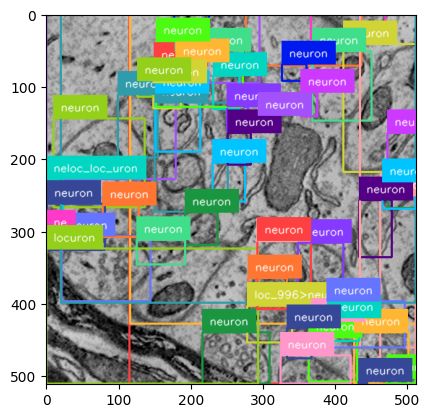

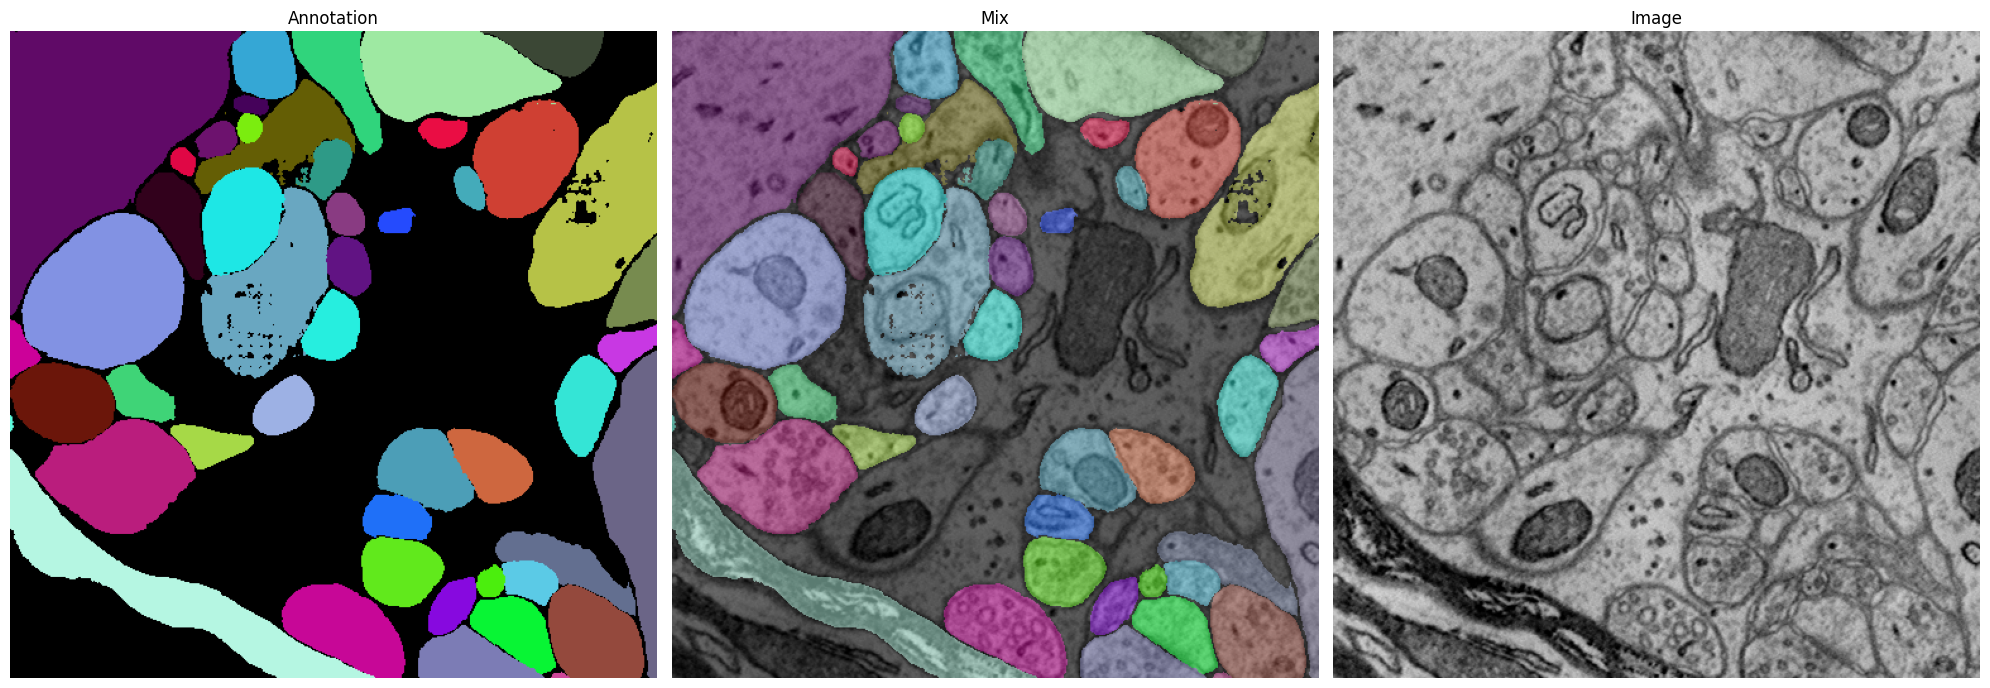

In [8]:
# - Florence2 + SAM2 Test Sample Image: only bboxes
image_path = all_test_slices[0]
num_labels, bboxes, image = flo_infer_bboxes(image_path, 2048)
print(f'the number of labels: {num_labels}')
# - Fliter Invalid Bound Boxes
bboxes = validate_boxes(bboxes)
image = cv2.imread(str(image_path))
predict_seg('boxes', image , None, None, input_boxes = bboxes)